In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
from google.colab import drive
import pandas as pd
from PIL import Image
import seaborn as sns
from datetime import datetime

In [15]:
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
BASE_DIR = '/content/drive/MyDrive/TA/dtcpr'
MODEL_PATH = os.path.join(BASE_DIR, 'hasil/model_karies_gigi_final.h5')  # Model terbaik
IMG_SIZE = 224

# Threshold untuk klasifikasi (bisa di-adjust)
CONFIDENCE_THRESHOLD = 0.5

In [17]:
def load_trained_model(model_path):
    """
    Load model yang sudah dilatih
    """
    try:
        model = load_model(model_path)
        print(f"✅ Model berhasil dimuat dari: {model_path}")
        print(f"📊 Model input shape: {model.input_shape}")
        return model
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None


In [18]:
# Load model
model = load_trained_model(MODEL_PATH)

✅ Model berhasil dimuat dari: /content/drive/MyDrive/TA/dtcpr/hasil/model_karies_gigi_final.h5
📊 Model input shape: (None, 224, 224, 3)


In [19]:
def preprocess_image_for_prediction(img_path, target_size=(224, 224)):
    """
    Preprocess gambar untuk prediksi (sama seperti training)
    """
    try:
        # Load image
        if isinstance(img_path, str):
            # Jika input adalah path file
            img = cv2.imread(img_path)
            if img is None:
                print(f"❌ Tidak bisa membaca gambar: {img_path}")
                return None
        else:
            # Jika input sudah berupa array
            img = img_path

        # Convert BGR to RGB (OpenCV uses BGR)
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize ke ukuran yang diharapkan model
        img_resized = cv2.resize(img, target_size)

        # Normalize ke range [0,1] (sama seperti training)
        img_normalized = img_resized.astype('float32') / 255.0

        # Add batch dimension
        img_batch = np.expand_dims(img_normalized, axis=0)

        return img_batch, img_resized

    except Exception as e:
        print(f"❌ Error preprocessing image: {e}")
        return None, None

In [20]:
def predict_single_image(model, img_path, show_image=True):
    """
    Prediksi untuk satu gambar
    """
    # Preprocess image
    img_processed, img_display = preprocess_image_for_prediction(img_path)

    if img_processed is None:
        return None

    # Prediksi
    prediction_prob = model.predict(img_processed, verbose=0)[0][0]

    # Klasifikasi berdasarkan threshold
    prediction_class = "Karies" if prediction_prob > CONFIDENCE_THRESHOLD else "Sehat"
    confidence = prediction_prob if prediction_prob > 0.5 else (1 - prediction_prob)

    # Hasil prediksi
    result = {
        'image_path': img_path,
        'prediction_class': prediction_class,
        'probability_karies': prediction_prob,
        'probability_sehat': 1 - prediction_prob,
        'confidence': confidence,
        'confidence_percentage': confidence * 100
    }

    # Tampilkan hasil
    if show_image and img_display is not None:
        plt.figure(figsize=(8, 6))
        plt.imshow(img_display)
        plt.title(f'Prediksi: {prediction_class}\n' +
                 f'Confidence: {confidence:.2%}\n' +
                 f'Prob Karies: {prediction_prob:.3f} | Prob Sehat: {1-prediction_prob:.3f}')
        plt.axis('off')

        # Color coding untuk hasil
        if prediction_class == "Karies":
            plt.gca().add_patch(plt.Rectangle((0, 0), img_display.shape[1], img_display.shape[0],
                                            fill=False, edgecolor='red', linewidth=5))
        else:
            plt.gca().add_patch(plt.Rectangle((0, 0), img_display.shape[1], img_display.shape[0],
                                            fill=False, edgecolor='green', linewidth=5))
        plt.show()

    return result

# batch

In [21]:
def predict_batch_images(model, image_folder, save_results=True):
    """
    Prediksi untuk multiple images dalam folder
    """
    # Supported image extensions
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

    # Get all image files
    image_files = []
    for ext in valid_extensions:
        image_files.extend([f for f in os.listdir(image_folder) if f.lower().endswith(ext)])

    if not image_files:
        print("❌ Tidak ada gambar ditemukan dalam folder!")
        return None

    print(f"🔍 Ditemukan {len(image_files)} gambar untuk diprediksi...")

    results = []

    # Process each image
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(image_folder, img_file)
        print(f"📷 Processing {i+1}/{len(image_files)}: {img_file}")

        result = predict_single_image(model, img_path, show_image=False)
        if result:
            result['filename'] = img_file
            results.append(result)

    # Convert to DataFrame for easy analysis
    df_results = pd.DataFrame(results)

    # Summary statistics
    print(f"\n📊 RINGKASAN HASIL PREDIKSI:")
    print(f"Total gambar: {len(results)}")
    print(f"Prediksi Karies: {sum(1 for r in results if r['prediction_class'] == 'Karies')}")
    print(f"Prediksi Sehat: {sum(1 for r in results if r['prediction_class'] == 'Sehat')}")
    print(f"Confidence rata-rata: {np.mean([r['confidence'] for r in results]):.2%}")

    # Save results
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        results_path = os.path.join(BASE_DIR, f'hasil_prediksi_{timestamp}.csv')
        df_results.to_csv(results_path, index=False)
        print(f"💾 Hasil disimpan ke: {results_path}")

    return df_results


In [22]:
def visualize_batch_results(df_results, max_images=12):
    """
    Visualisasi hasil prediksi batch
    """
    if df_results is None or len(df_results) == 0:
        print("❌ Tidak ada data untuk divisualisasi!")
        return

    # Limit number of images to display
    display_df = df_results.head(max_images)

    # Calculate grid size
    n_images = len(display_df)
    cols = min(4, n_images)
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    for i, (_, row) in enumerate(display_df.iterrows()):
        if i >= len(axes):
            break

        # Load and display image
        img_path = row['image_path']
        img = cv2.imread(img_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))

            axes[i].imshow(img_resized)

            # Title with prediction info
            title = f"{row['filename']}\n{row['prediction_class']} ({row['confidence_percentage']:.1f}%)"
            color = 'red' if row['prediction_class'] == 'Karies' else 'green'
            axes[i].set_title(title, color=color, fontweight='bold')
            axes[i].axis('off')

    # Hide unused subplots
    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # Summary plot
    plt.figure(figsize=(12, 4))

    # Pie chart of predictions
    plt.subplot(1, 3, 1)
    prediction_counts = df_results['prediction_class'].value_counts()

    # Pastikan warna sesuai dengan label: Merah untuk Karies, Hijau untuk Sehat
    colors = []
    for label in prediction_counts.index:
        if label == 'Karies':
            colors.append('red')  # Merah untuk Karies
        else:  # Sehat
            colors.append('green')  # Hijau untuk Sehat

    plt.pie(prediction_counts.values, labels=prediction_counts.index, autopct='%1.1f%%', colors=colors)
    plt.title('Distribusi Prediksi')

    plt.tight_layout()
    plt.show()

In [23]:
def advanced_prediction_analysis(model, img_path):
    """
    Analisis prediksi yang lebih detail dengan confidence intervals
    """
    # Multiple predictions with different preprocessing
    predictions = []

    # Original prediction
    result = predict_single_image(model, img_path, show_image=False)
    if result:
        predictions.append(result['probability_karies'])

    # Test with slight variations (Test Time Augmentation)
    img = cv2.imread(img_path)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Slight rotations
        for angle in [-5, 0, 5]:
            center = (img_rgb.shape[1]//2, img_rgb.shape[0]//2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated = cv2.warpAffine(img_rgb, rotation_matrix, (img_rgb.shape[1], img_rgb.shape[0]))

            img_processed, _ = preprocess_image_for_prediction(rotated)
            if img_processed is not None:
                pred_prob = model.predict(img_processed, verbose=0)[0][0]
                predictions.append(pred_prob)

        # Brightness variations
        for brightness in [0.9, 1.0, 1.1]:
            bright_img = np.clip(img_rgb * brightness, 0, 255).astype(np.uint8)
            img_processed, _ = preprocess_image_for_prediction(bright_img)
            if img_processed is not None:
                pred_prob = model.predict(img_processed, verbose=0)[0][0]
                predictions.append(pred_prob)

    # Calculate statistics
    mean_prob = np.mean(predictions)
    std_prob = np.std(predictions)
    confidence_interval = (mean_prob - 1.96*std_prob, mean_prob + 1.96*std_prob)

    # Final prediction
    final_class = "Karies" if mean_prob > CONFIDENCE_THRESHOLD else "Sehat"
    uncertainty = std_prob

    print(f"🔬 ANALISIS PREDIKSI LANJUTAN:")
    print(f"📊 Rata-rata probabilitas karies: {mean_prob:.3f}")
    print(f"📊 Standard deviasi: {std_prob:.3f}")
    print(f"📊 Confidence interval 95%: ({confidence_interval[0]:.3f}, {confidence_interval[1]:.3f})")
    print(f"📊 Uncertainty score: {uncertainty:.3f}")
    print(f"🎯 Prediksi final: {final_class}")

    if uncertainty > 0.1:
        print("⚠️  High uncertainty - sebaiknya konsultasi dengan dokter")
    elif uncertainty > 0.05:
        print("⚠️  Moderate uncertainty - perlu verifikasi tambahan")
    else:
        print("✅ Low uncertainty - prediksi cukup confident")

    return {
        'mean_probability': mean_prob,
        'std_probability': std_prob,
        'confidence_interval': confidence_interval,
        'final_prediction': final_class,
        'uncertainty_score': uncertainty,
        'all_predictions': predictions
    }

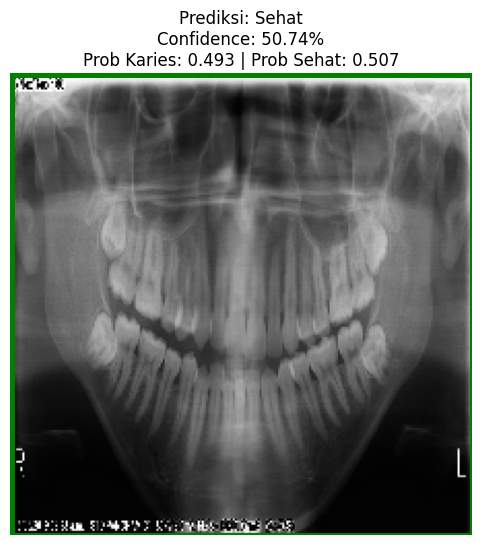

In [24]:
result = predict_single_image(model, '/content/drive/MyDrive/TA/databasefic/sehat/49.jpg')

🔍 Ditemukan 321 gambar untuk diprediksi...
📷 Processing 1/321: 10.jpg
📷 Processing 2/321: 104.jpg
📷 Processing 3/321: 110.jpg
📷 Processing 4/321: 107.jpg
📷 Processing 5/321: 101.jpg
📷 Processing 6/321: 112.jpg
📷 Processing 7/321: 102.jpg
📷 Processing 8/321: 116.jpg
📷 Processing 9/321: 105.jpg
📷 Processing 10/321: 11.jpg
📷 Processing 11/321: 114.jpg
📷 Processing 12/321: 1.jpg
📷 Processing 13/321: 141.jpg
📷 Processing 14/321: 140.jpg
📷 Processing 15/321: 133.jpg
📷 Processing 16/321: 151.jpg
📷 Processing 17/321: 150.jpg
📷 Processing 18/321: 134.jpg
📷 Processing 19/321: 137.jpg
📷 Processing 20/321: 146.jpg
📷 Processing 21/321: 124.jpg
📷 Processing 22/321: 131.jpg
📷 Processing 23/321: 126.jpg
📷 Processing 24/321: 127.jpg
📷 Processing 25/321: 145.jpg
📷 Processing 26/321: 143.jpg
📷 Processing 27/321: 136.jpg
📷 Processing 28/321: 139.jpg
📷 Processing 29/321: 149.jpg
📷 Processing 30/321: 125.jpg
📷 Processing 31/321: 142.jpg
📷 Processing 32/321: 132.jpg
📷 Processing 33/321: 118.jpg
📷 Processing 

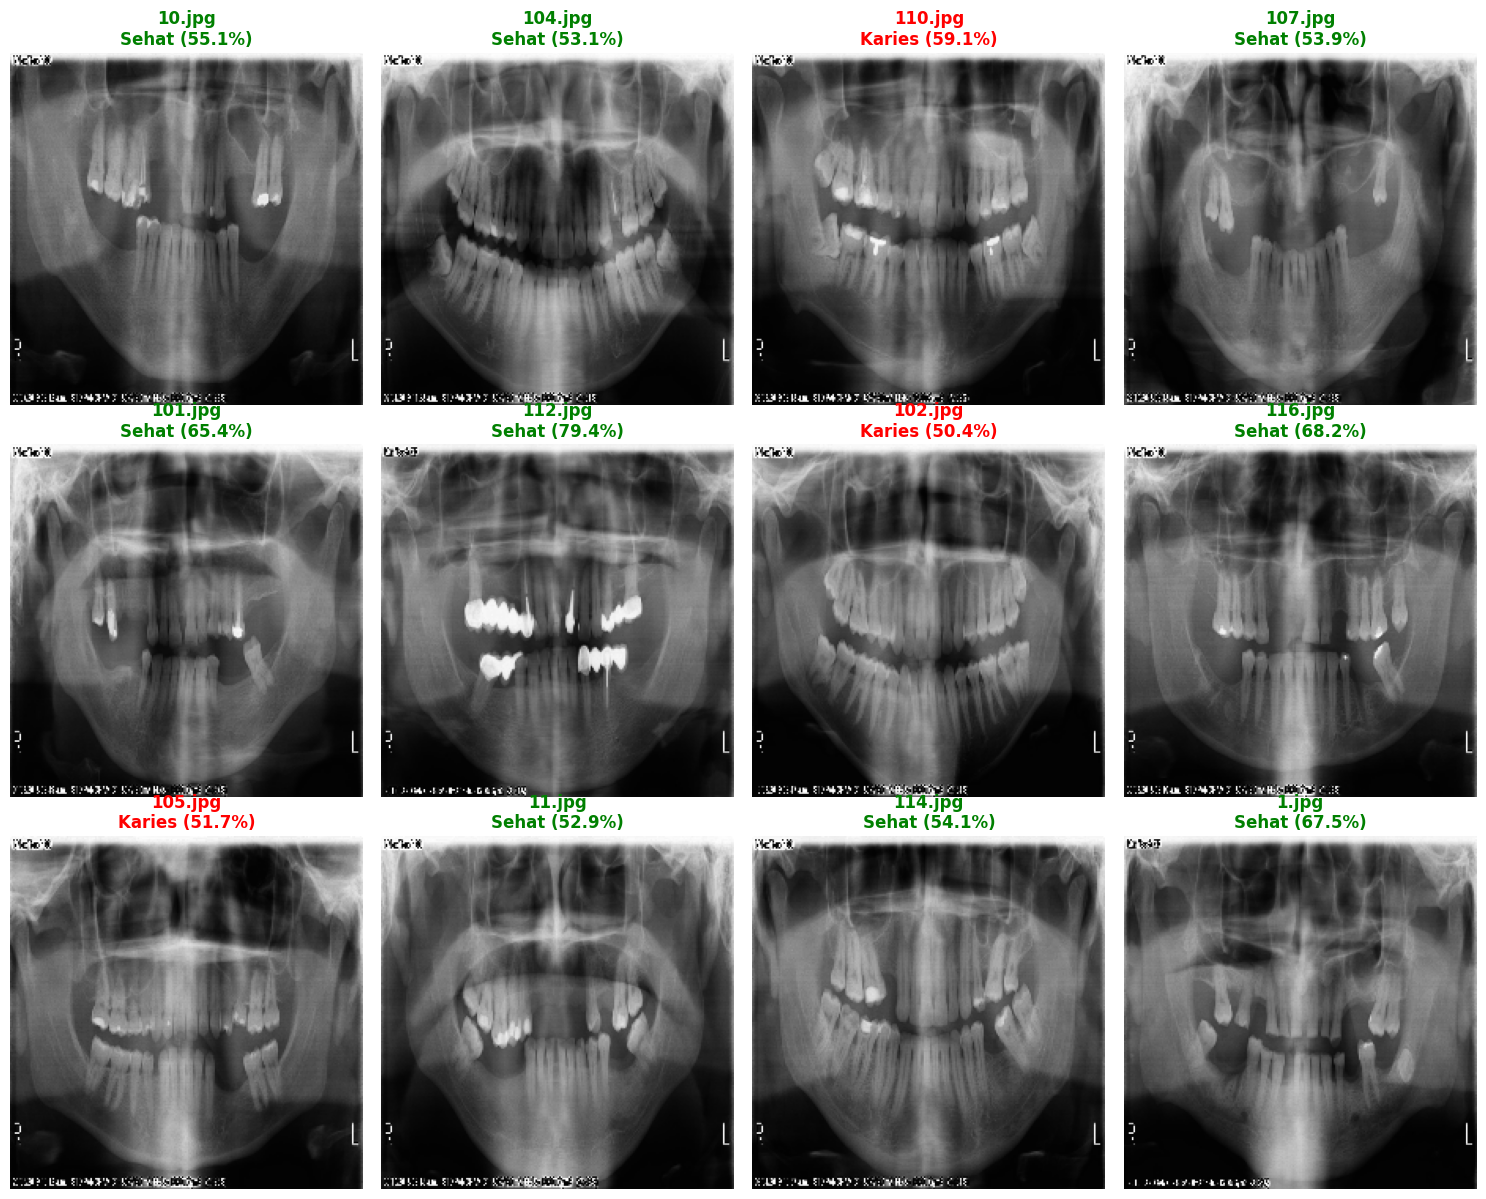

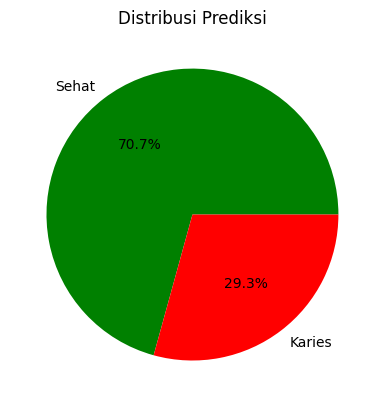

In [29]:
df_results = predict_batch_images(model, '/content/drive/MyDrive/TA/databasefic/sehat')
visualize_batch_results(df_results)

In [26]:
advanced_result = advanced_prediction_analysis(model, '/content/drive/MyDrive/TA/databasefic/sehat/49.jpg')

🔬 ANALISIS PREDIKSI LANJUTAN:
📊 Rata-rata probabilitas karies: 0.482
📊 Standard deviasi: 0.028
📊 Confidence interval 95%: (0.428, 0.535)
📊 Uncertainty score: 0.028
🎯 Prediksi final: Sehat
✅ Low uncertainty - prediksi cukup confident
